# NARMA10 task

This task consists in predicting the output of a 10-th order non-linear autoregressive moving average (NARMA) system.
- [Reference paper](https://doi.org/10.1016/j.neunet.2011.02.002)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import itertools

import torch
from torch import cuda, zeros, Tensor, optim
from torch.nn import Module, ModuleList, Sequential, Linear, Tanh, MSELoss, RNN

# from grid import GS


The input of the system is a sequence of elements 𝑥(𝑡) randomly chosen according to a uniform distribution over [0, 0.5]. 

Given the input value 𝑥(𝑡), the task is to predict the corresponding value of 𝑦(𝑡).

- Import the dataset from the .csv file *NARMA10.csv*, where the first row represents the input and the second row represents the
target output. Different columns represent different time-steps.
- Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
    - For the sake of problem understanding, you can try to first visualize the timeseries data

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
dset = pd.read_csv('../data/NARMA10.csv', header=None).to_numpy()
x = dset[0]
y = dset[1]
x_test = x[:5000]
train = x[5000:] 

x_train = train[:4000]
x_val = train[4000:]

y_test = y[:5000]
train_y = y[5000:] 

y_train = train_y[:4000]
y_val = train_y[4000:]

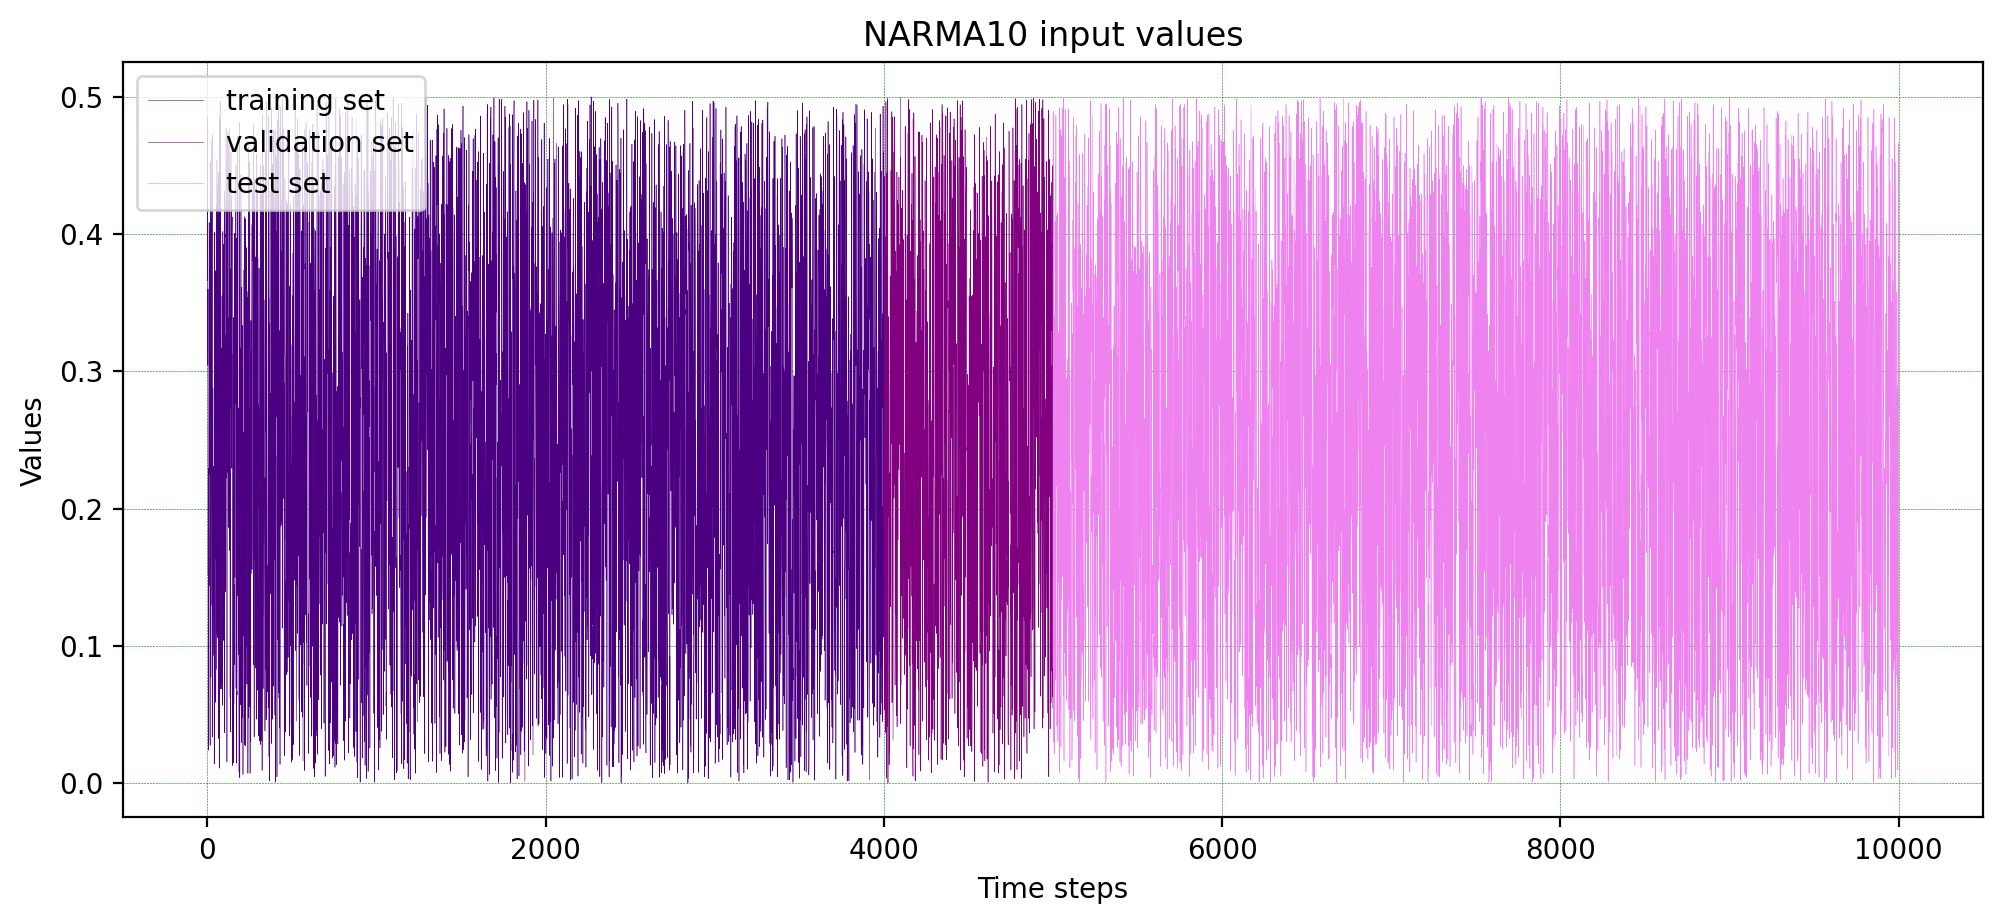

In [4]:
# plot_ts(x_train,x_val,x_test, "NARMA10 input values")

limit1=int(x_train.shape[0])
limit2=int(x_train.shape[0]+x_val.shape[0])
limit3=int(limit2+x_test.shape[0])

plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(0,limit1), x_train, color="indigo", linewidth=0.2, label="training set") 
plt.plot(range(limit1,limit2), x_val, color="purple", linewidth=0.2, label="validation set") 
plt.plot(range(limit2,limit3), x_test, color="violet", linewidth=0.2, label="test set") 

plt.title('NARMA10 input values')
plt.xlabel("Time steps")
plt.ylabel("Values")
plt.legend()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
#plt.savefig(str('plots/timeseries.jpeg'), edgecolor='black', dpi=400, transparent=True)
plt.show()

**Remember:** when training an RNN you want to make sure to keep the last hidden state of your RNN after the training session, and use it as initial hidden state of the validation session.
Same applies when transitioning to the test session

In [5]:
# This class `GS` implements a grid search algorithm to find the best model configuration for either a
# TDNN or RNN neural network based on specified parameters and datasets.
class GS:
    
    def __init__(self, parameters:dict, Xset, Yset, neuralnet:str):
        self.Xset=Xset
        self.Yset=Yset
        param_grid = self.grid(parameters) #self, 
        min_loss, best_model = self.search(param_grid, neuralnet) #self, 
        self.min_loss = min_loss
        self.best_model = best_model # the best model discovered

    # @staticmethod
    def grid(self, params):
        param_names=list(params.keys())
        param_values=list(params.values())
        param_combinations=list(itertools.product(*param_values))
        
        param_grid=[]
        for combination in param_combinations:
            param_grid.append(dict(zip(param_names, combination)))
        return param_grid 
        
    @staticmethod
    def get_optimizer(model, optimizer_name, lr):
        if optimizer_name == 'adam':
            return optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'sgd':
            return optim.SGD(model.parameters(), lr=lr)
        else:
            raise ValueError("Unknown optimizer: {}".format(optimizer_name))
        
    # @staticmethod
    def search(self, param_grid:tuple, neuralnet:str):#, Xset, Yset):
        predictions={}  
        for pg in param_grid:
            if neuralnet=='TDNN':
                model=TDNN_model(
                    window=pg['window'],
                    layers=pg['hiddens'],
                    input_dim=self.Xset.shape[0],
                    epochs=pg['epochs'],
                    hidden_dim=10 # CONSIDER GRID SEARCHING THIS ALSO
                    #   THOSE TO BE PASED TO .forward AND .train METHODS       
                )
            elif neuralnet=='RNN':
                model=RNN_model(
                    input_dim=self.Xset.size(0), #self.Xset.shape[1]
                    layers=pg['hiddens'],
                    #   THOSE TO BE PASSED TO .forward AND .train METHODS
                    epochs=pg['epochs'],
                    hidden_dim=10 # CONSIDER GRID SEARCHING THIS ALSO
                ) 
            optimizer = self.get_optimizer(model, pg['opt'], pg['lr'])      
            loss, y_pred=model.train(self.Xset, self.Yset, optimizer)# pg['lr']) #pg['opt'],
            predictions[loss]=[pg, y_pred] 
        
        
        # predictions=dict(sorted(predictions.items()))
        # print(next(iter(predictions.items())))
        # min_loss=list(predictions.keys())[0]
        min_loss = min(predictions.keys())
        # best_model=list(predictions.values())[0]
        best_model = predictions[min_loss]
        
        return min_loss, best_model

In [6]:
# With this function, you obtain a 1x[window_size]x4000 Torch Tensor 
# to pass to the TDNN as preprocessed input data

def input_prep(window:int, input_data:np.array):
        input_len=len(input_data)
        prep_input=torch.zeros([1, input_len, window])
        for i in range(0, input_len):
            #if((i+window) <= input_len): 
                tmp=input_data[i:i+window]
                #prep_input[0,i,:]=tmp 
                for j in tmp:
                    prep_input[0,i,:]=j
        # print('TENSOR:', prep_input.shape)
        return prep_input


In [7]:
def plot_results(tr_y_pred, tr_y, ts_y_pred, ts_y, nn):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Narma10 task with {nn}')
    
    plt.subplot(2, 1, 1)
    plt.plot(tr_y_pred, label="Prediction")
    plt.plot(tr_y, label="Target")
    plt.title("Model selection")
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(ts_y_pred, label="Prediction")
    plt.plot(ts_y, label="Target")
    plt.title("Final retraining")
    plt.grid()
    plt.legend()

    plt.show()


In [8]:
############################
#   TDNN: every epoch you pass all the matrix input (window)
#   RNN: every epoch you pass a timestep and let it run
############################

## Time-delay neural network

In [9]:
''' 
This is a PyTorch neural network model class that implements a simple TDNN architecture with a
specified number of hidden layers and dimensions. 
'''

class TDNN_model(torch.nn.Module):
    def __init__(self, window:int, layers:int, input_dim:int, epochs:int, hidden_dim:int): #, output_func): # WINDOW:TAU
        super(TDNN_model, self).__init__()
        
        hidden_layers = [] #torch.nn.ModuleList()
        # hidden = torch.nn.ModuleList([torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim)])
        # self.all_layers.append([hidden for i in range(1,layers)])
        
        for _ in range(layers):
            hidden_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
            hidden_layers.append(torch.nn.ReLU())
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(window, hidden_dim), #window*input_dim
            torch.nn.ReLU(),
            *hidden_layers,
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Tanh()
            ) 
        
        
        self.window=window   
        self.epochs=epochs   
        # self.optimizer = optim      
        
                
    def train(self, input_data:Tensor, target_data:Tensor, optimizer):#, lrate:int): #, optimizer):
        #create sequences of data
        timesteps=input_prep(self.window, input_data)
        #pass them to the model        
        #then to the optimizer
        target=input_prep(self.window, target_data)
        #optimizer to be inserted in grid
        for e in range(1,self.epochs):
            # print("EPOCH ", e, "\n-----------------------------------------------------")
            # optimizer=torch.optim.SGD(params=params, lr=params["lr"])
            y_pred = self.model(timesteps)
            mse = MSELoss()
            loss = mse(y_pred, target) # !! here you might insert a condition for a certain number of previous losses such that 
                                        # if they're all the same (=not learning anymore) you stop
        if loss is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()           
            #catch loss and history and get them back to the grid search for storage and evaluation
            return(round(loss.item(), 4), y_pred)    

In [10]:
# adam=torch.optim.Adam()
# sgd=torch.optim.SGD()
params={
    'epochs':[100], #200, 500],
    'hiddens':[1,2,3],#5],
    'window':[3,5],#10,15],
    'lr':[0.0001, 0.001],# 0.01]
    'opt':['adam', 'sgd']
    #act:[nn.Sigmoid(), nn.Tanh]
}

In [11]:
nn='TDNN'
grid_search=GS(params, x_train, y_train, nn) 
best_loss, best_model=grid_search.min_loss, grid_search.best_model
print('best training loss: ', best_loss)#, '\n best training model: ', best_model)
grid_search_val=GS(params, x_val, y_val, nn) 
best_loss_val, best_model_val=grid_search.min_loss, grid_search.best_model
best_params = best_model_val[0]
print('Cross validation: \n best loss on validation: ', best_loss_val, '\n best model parametrization based on validation: ',best_params)


c:\Users\Francesca\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1, 4000, 3])) that is different to the input size (torch.Size([1, 4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Francesca\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1, 4000, 5])) that is different to the input size (torch.Size([1, 4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


best training loss:  0.0076


c:\Users\Francesca\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1, 1000, 3])) that is different to the input size (torch.Size([1, 1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Francesca\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1, 1000, 5])) that is different to the input size (torch.Size([1, 1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Cross validation: 
 best loss on validation:  0.0076 
 best model parametrization based on validation:  {'epochs': 100, 'hiddens': 3, 'window': 5, 'lr': 0.0001, 'opt': 'adam'}


##### Final retraining

In [12]:
tdnn = TDNN_model(best_params['window'], best_params['hiddens'], x_val.shape[0], best_params['epochs'], 10 )
optimizer = GS.get_optimizer(tdnn, best_params['opt'], best_params['lr'])  
val_loss, val_ypred=tdnn.train(x_val, y_val,optimizer) 
# best_loss_val, best_model_val=grid_search.min_loss, grid_search.best_model
# grid_search_test=GS(params, x_test, y_test, nn) 
# best_loss_test, best_model_test=grid_search.min_loss, grid_search.best_model
tdnn = TDNN_model(best_params['window'], best_params['hiddens'], x_test.shape[0], best_params['epochs'], 10 )
optimizer = GS.get_optimizer(tdnn, best_params['opt'], best_params['lr'])  
test_loss, test_ypred=tdnn.train(x_test, y_test,optimizer) 

print('Best loss: \n validation: ', val_loss, '\n test: ', test_loss)


c:\Users\Francesca\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1, 5000, 5])) that is different to the input size (torch.Size([1, 5000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Best loss: 
 validation:  0.1857 
 test:  0.0164


ValueError: x and y can be no greater than 2D, but have shapes (1,) and torch.Size([1, 4000, 1])

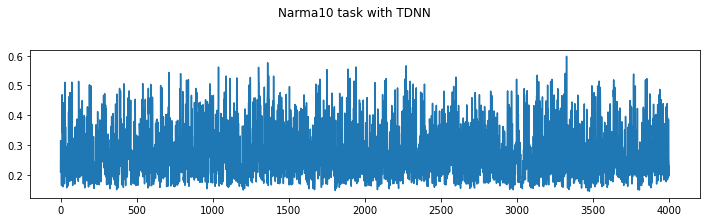

In [13]:
plot_results(y_train, best_model[1], y_test, test_ypred, nn)

## Recurrent neural network

In [ ]:
''' 
This is a PyTorch neural network model class that implements a simple RNN architecture with a
specified number of hidden layers and dimensions. 
'''

class RNN_model(torch.nn.Module):
    def __init__(self, input_dim:int, layers:int, epochs:int, hidden_dim:int):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layers = layers

        self.rnn = torch.nn.RNN(input_dim, hidden_dim, layers, nonlinearity='relu', bias=False, batch_first=True)
        self.readout = torch.nn.Linear(hidden_dim, 1)
        
        self.epochs=epochs
    
    ############## ORIGINAL ONE ######################
    # def forward(self, x):
    #     '''
    #     x.size = [1, 4000, 1]
    #     '''
    #     # h0 = torch.zeros(self.layers, x.size(1), self.hidden_dim)
    #     # print('element ')
    #     h0 = torch.zeros(self.layers, x.size(0), self.hidden_dim)
    #     # print('h0: ', h0.shape)

    #     # One time step
    #     for i in range(x.size(1)):
    #         # print(x[:, i, :], x[:, i, :].shape) ###############HERE IS THE ERROR!!!!!!!!!!!!!!!!
    #         out, hn = self.rnn(x[:, i, :], h0) ########## x[:, :i, :] IS AN EMPTY TENSOR!!!!!!!!!!!!!!!!!!!! BUT IT WAS YOUR FIRST CHOICE, REMEMBER THAT
    #         print("out: ", out.shape, "hn: ", hn.shape)
    #     # print('out: ', out.shape)
    #     out = self.readout(hn[:, 1, :]) 
    #     return out
    ############### NEW ONE #################
    def forward(self, x):
        h0 = torch.zeros(self.layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.readout(out[:, -1, :])
        return out
    
    
    
    def train(self, input_data:Tensor, target_data:Tensor, optimizer):
        # input_data = input_data#.float()  # Ensure input_data is FloatTensor
        # target_data = target_data#.float()  # Ensure target_data is FloatTensor
        for e in range(1,self.epochs):
            # print("EPOCH ", e, "\n-----------------------------------------------------")
            # optimizer=torch.optim.SGD(params=params, lr=params["lr"])
            # print('input shape: ', input_data.shape)
            y_pred = self.forward(input_data)
            mse = MSELoss()
            loss = mse(y_pred, target_data)
            # loss= round(loss.item(), 4)# !! here you might insert a condition for a certain number of previous losses that if they're all the same (=not learning anymore) you stop
            # print('\tloss:',loss, '\n')
        if loss is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()           
            ###catch loss and history and get them back to the grid search for storage and evaluation
            return(round(loss.item(), 4), y_pred)    
        


In [ ]:
# adam=torch.optim.Adam()
# sgd=torch.optim.SGD()
params={
    'epochs':[100], #200, 500],
    'hiddens':[1,2,3],
    # 'window':[3,5],#10,15],
    'lr':[0.0001, 0.001],# 0.01]
    'opt':['adam', 'sgd']
    #act:[nn.Sigmoid(), nn.Tanh]
}

nn='RNN'
x_tr =  torch.from_numpy(np.reshape(x_train, (1, 4000, 1))).float() 
y_tr =  torch.from_numpy(np.reshape(y_train, (1, 4000, 1))).float() 

x_v =  torch.from_numpy(np.reshape(x_val, (1, 1000, 1))).float() 
y_v =  torch.from_numpy(np.reshape(y_val, (1, 1000, 1))).float() 


grid_search=GS(params, x_tr, y_tr, nn) 
best_loss, best_model=grid_search.min_loss, grid_search.best_model
# print('best loss: ', best_loss, '\n best model: ', best_model)
print('best training loss: ', best_loss)#, '\n best training model: ', best_model)
grid_search_val=GS(params, x_v, y_v, nn) 
best_loss_val, best_model_val=grid_search.min_loss, grid_search.best_model
best_params = best_model_val[0]
print('Cross validation: \n best loss on validation: ', best_loss_val, '\n best model parametrization based on validation: ',best_params)

##### Final retraining

In [ ]:
x_t =  torch.from_numpy(np.reshape(x_test, (1, 5000, 1))).float() 
y_t =  torch.from_numpy(np.reshape(y_test, (1, 5000, 1))).float() 

rnn = RNN_model(x_v.size(0), best_params['hiddens'], best_params['epochs'], 10)
optimizer = GS.get_optimizer(rnn, best_params['opt'], best_params['lr'])  
val_loss, val_ypred=rnn.train(x_v, y_v,optimizer) 
# best_loss_val, best_model_val=grid_search.min_loss, grid_search.best_model
# grid_search_test=GS(params, x_test, y_test, nn) 
# best_loss_test, best_model_test=grid_search.min_loss, grid_search.best_model
rnn = RNN_model(x_t.size(0), best_params['hiddens'], best_params['epochs'], 10)
optimizer = GS.get_optimizer(rnn, best_params['opt'], best_params['lr'])  
test_loss, test_ypred=rnn.train(x_t, y_t,optimizer) 

print('Best loss: \n validation: ', val_loss, '\n test: ', test_loss)


In [ ]:
plot_results(y_tr, best_model[1], y_t, test_ypred, nn)